In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.figsize'] = (5.0, 0.8) 
import matplotlib.patches as mpatches
from util.color_util import *
import pickle
from random import shuffle
import torch.optim as optim
import colorsys
from model.RSA import *
from model.WM18 import *
from numpy import dot
from numpy.linalg import norm
from scipy import spatial
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from skimage import io, color
import random
from tabulate import tabulate

In [2]:
RGB = True
EXTEND = True
NUM_EPOCHE = 1000
RETRAIN = False
FOURIER_TRANSFORM = False
SAMPLE_PER_COLOR = 3
COLOR_DIM = 54 if FOURIER_TRANSFORM else 3

In [3]:
# load triples
if EXTEND:
    triple_train = pickle.load( open( "../munroe/triple_train.p", "rb" ) )
    triple_dev = pickle.load( open( "../munroe/triple_dev.p", "rb" ) )
    triple_test = pickle.load( open( "../munroe/triple_test.p", "rb" ) )
else:
    triple_train = pickle.load( open( "../munroe/triple_train_reduce.p", "rb" ) )
    triple_dev = pickle.load( open( "../munroe/triple_dev_reduce.p", "rb" ) )
    triple_test = pickle.load( open( "../munroe/triple_test_reduce.p", "rb" ) )
    
# load colors
cdict_train_rgb = pickle.load( open( "../munroe/cdict_train.p", "rb" ) )
cdict_dev_rgb = pickle.load( open( "../munroe/cdict_dev.p", "rb" ) )
cdict_test_rgb = pickle.load( open( "../munroe/cdict_test.p", "rb" ) )

cdict_train = dict()
cdict_dev = dict()
cdict_test = dict()

if RGB:
    cdict_train = cdict_train_rgb
    cdict_dev = cdict_dev_rgb
    cdict_test = cdict_test_rgb
else:
    for c in cdict_train_rgb.keys():
        cdict_train[c] = torch.tensor(colors.rgb_to_hsv(cdict_train_rgb[c]))
    for c in cdict_dev_rgb.keys():
        cdict_dev[c] = torch.tensor(colors.rgb_to_hsv(cdict_dev_rgb[c]))
    for c in cdict_test_rgb.keys():
        cdict_test[c] = torch.tensor(colors.rgb_to_hsv(cdict_test_rgb[c]))

# load embeddings for this dataset only
embeddings = pickle.load( open( "../munroe/glove_color.p", "rb" ) )

# generate test sets
test_set = generate_test_set(triple_train, triple_test)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# load literal speaker
literal_s = WM18(color_dim=COLOR_DIM)
checkpoint = torch.load("./save_model/" + "wm18_model" + ".pth")
literal_s.load_state_dict(checkpoint['model'])
# load literal listener
literal_l = WM18(color_dim=COLOR_DIM)
checkpoint = torch.load("./save_model/" + "literal_listener_wm18" + ".pth")
literal_l.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [31]:
count_parameters(literal_s)

18222

In [32]:
count_parameters(literal_l)

18222

In [21]:
net_predict = predict_color(literal_s, test_set, cdict_test, embeddings, sample_per_color=10, fourier=FOURIER_TRANSFORM)

predict seen_pair set with 312 samples.
predict unseen_pair set with 18 samples.
predict unseen_base set with 62 samples.
predict unseen_mod set with 41 samples.
predict unseen_fully set with 17 samples.
predict overall set with 450 samples.


In [22]:
# level 1 pragmatic where this is no listener involve
pragmatic_predict_result = pragmatic_predict(net_predict, level="s1")

In [23]:
evaluation_metrics = evaluate_color(net_predict, fmt="rgb", reduced=True)

condition     cosine (std)    delta_E (std)
------------  --------------  ---------------
seen_pair     0.945 (0.135)   4.403 (3.158)
unseen_pair   0.840 (0.355)   4.954 (2.431)
unseen_base   0.793 (0.401)   8.814 (5.679)
unseen_mod    0.595 (0.469)   11.602 (5.892)
unseen_fully  0.527 (0.587)   13.777 (8.383)
overall       0.872 (0.293)   6.020 (5.019)


In [24]:
evaluation_metrics = evaluate_color(net_predict, fmt="rgb", reduced=False)

condition     cosine (std)    delta_E (std)
------------  --------------  ---------------
seen_pair     0.929 (0.137)   4.740 (3.024)
unseen_pair   0.803 (0.363)   5.144 (2.382)
unseen_base   0.782 (0.387)   9.094 (5.530)
unseen_mod    0.592 (0.465)   11.775 (5.936)
unseen_fully  0.525 (0.582)   13.885 (8.351)
overall       0.858 (0.288)   6.320 (4.896)


In [25]:
evaluation_metrics = evaluate_color(pragmatic_predict_result, fmt="rgb", eval_target="pred_delta_e_s1")

condition     cosine (std)    delta_E (std)
------------  --------------  ---------------
seen_pair     0.926 (0.157)   5.026 (3.216)
unseen_pair   0.823 (0.388)   5.719 (2.773)
unseen_base   0.751 (0.444)   10.101 (5.508)
unseen_mod    0.603 (0.472)   13.187 (7.350)
unseen_fully  0.552 (0.599)   15.025 (8.515)
overall       0.855 (0.312)   6.882 (5.315)


In [26]:
def pragmatic_predict(net_predict, literal_listener=None, level="s1", lambda_pragmatic=0.1):
    for set_name in net_predict.keys():
        for triple in net_predict[set_name].keys():
            sample_cos = []
            sample_delta_e = []
            index = 0
            batch_emb1 = net_predict[set_name][triple]["embeddings_1"]
            batch_emb2 = net_predict[set_name][triple]["embeddings_2"]
            sample_base_cos = []
            sample_base_delta_e = []
            for sample in net_predict[set_name][triple]["pred"]:
                pred_sample = sample.detach().numpy()
                base = net_predict[set_name][triple]["base"].detach().numpy()[0]
                # prob based on cosine
                cos_dis = spatial.distance.cosine(pred_sample, base)
                sample_cos.append(cos_dis)
                # prob based on delta_e
                c1 = sRGBColor(rgb_r=pred_sample[0], rgb_g=pred_sample[1], rgb_b=pred_sample[2])
                c2 = sRGBColor(rgb_r=base[0], rgb_g=base[1], rgb_b=base[2])
                # Convert from RGB to Lab Color Space
                color1_lab = convert_color(c1, LabColor)
                # Convert from RGB to Lab Color Space
                color2_lab = convert_color(c2, LabColor)
                delta_e = delta_e_cie2000(color1_lab, color2_lab)
                sample_delta_e.append(delta_e)
                
                if level == "s2" and literal_listener is not None:
                    emb1 = batch_emb1[index].unsqueeze(dim=0)
                    emb2 = batch_emb2[index].unsqueeze(dim=0)
                    base_pred = literal_listener(emb1, emb2, sample.unsqueeze(dim=0))[0]
                    # prob pred_base based on the real base
                    cos_sim = 1 - spatial.distance.cosine(base_pred.detach().numpy(), base)
                    sample_base_cos.append(cos_sim)
                    # prob based on delta_e
                    c1_b = sRGBColor(rgb_r=base_pred[0], rgb_g=base_pred[1], rgb_b=base_pred[2])
                    c2_b = sRGBColor(rgb_r=base[0], rgb_g=base[1], rgb_b=base[2])
                    # Convert from RGB to Lab Color Space
                    color1_lab_b = convert_color(c1_b, LabColor)
                    # Convert from RGB to Lab Color Space
                    color2_lab_b = convert_color(c2_b, LabColor)
                    delta_e_b = delta_e_cie2000(color1_lab_b, color2_lab_b)
                    sample_base_delta_e.append(delta_e_b)
                index += 1

            # s1 results
            cos_prob = sample_cos
            delta_e_prob = softmax_prob(sample_delta_e)
            combine_prob = np.multiply(cos_prob, delta_e_prob)
            cos_prob_n = np.argmax(cos_prob)
            delta_e_prob_n = np.argmax(delta_e_prob)
            combine_prob_n = np.argmax(combine_prob)
            all_sample = net_predict[set_name][triple]["pred"]
            net_predict[set_name][triple]["pred_cos_s1"] = \
                all_sample[cos_prob_n].unsqueeze(dim=0)
            net_predict[set_name][triple]["pred_delta_e_s1"] = \
                all_sample[delta_e_prob_n].unsqueeze(dim=0)
            net_predict[set_name][triple]["pred_combine_s1"] = \
                all_sample[combine_prob_n].unsqueeze(dim=0)
#             pred_weight = None
#             index = 0
#             for prob in delta_e_prob:
#                 if pred_weight is None:
#                     pred_weight = prob * all_sample[index]
#                 else:
#                     pred_weight += prob * all_sample[index]
#                 index += 1
#             net_predict[set_name][triple]["pred_weight_s1"] = \
#                 pred_weight.unsqueeze(dim=0)

            if level == "s2" and literal_listener is not None:
                # s2 results
                base_cos_prob = sample_base_cos
                base_delta_e_prob = softmax_prob(sample_base_delta_e)
                base_delta_e_prob = 1 - base_delta_e_prob
                base_combine_prob = np.multiply(base_cos_prob, base_delta_e_prob)
                base_cos_prob_n = np.argmax(base_cos_prob)
                base_delta_e_prob_n = np.argmax(base_delta_e_prob)
                base_combine_prob_n = np.argmax(base_combine_prob)
                all_sample = net_predict[set_name][triple]["pred"]
                net_predict[set_name][triple]["base_pred_cos_l1"] = \
                    all_sample[base_cos_prob_n].unsqueeze(dim=0)
                net_predict[set_name][triple]["base_pred_delta_e_l1"] = \
                    all_sample[base_delta_e_prob_n].unsqueeze(dim=0)
                net_predict[set_name][triple]["base_pred_combine_l1"] = \
                    all_sample[base_combine_prob_n].unsqueeze(dim=0)
#                 base_pred_weight = None
#                 index = 0
#                 for prob in base_combine_prob:
#                     if base_pred_weight is None:
#                         base_pred_weight = prob * all_sample[index]
#                     else:
#                         base_pred_weight += prob * all_sample[index]
#                     index += 1
#                 net_predict[set_name][triple]["base_pred_weight_l1"] = \
#                     base_pred_weight.unsqueeze(dim=0)
                base_pragmatic_prob = \
                    np.multiply((base_delta_e_prob ** lambda_pragmatic), 
                                (delta_e_prob ** (1 - lambda_pragmatic)))
                base_pragmatic_prob_n = np.argmax(base_pragmatic_prob)
                net_predict[set_name][triple]["base_pred_pragmatic_s2"] = \
                    all_sample[base_pragmatic_prob_n].unsqueeze(dim=0)
            
    return net_predict

In [27]:
# level 2 pragmatic where this is a listener involved
# 0.7 for delta
pragmatic_predict_result_lv2 = pragmatic_predict(net_predict, literal_listener=literal_l, level="s2", lambda_pragmatic=0.33)

In [28]:
evaluation_metrics = evaluate_color(pragmatic_predict_result_lv2, fmt="rgb", eval_target="base_pred_pragmatic_s2")

condition     cosine (std)    delta_E (std)
------------  --------------  ---------------
seen_pair     0.929 (0.154)   4.980 (3.176)
unseen_pair   0.834 (0.383)   5.786 (2.787)
unseen_base   0.775 (0.411)   9.819 (5.437)
unseen_mod    0.600 (0.484)   13.154 (7.435)
unseen_fully  0.564 (0.586)   15.020 (8.538)
overall       0.857 (0.311)   6.830 (5.315)


In [15]:
def plot_color_change_raw(source, direction, strength=1, save_path=None,
                          fmt="rgb"):
    '''
    compara: comparative color descriptions like `lighter`
    source_str: source color like `blue`
    strength: the ratio of exaggerating the effect to make it more perceivable
    '''
    ax = plt.gca()
    N = 100
    width, height = 1, 1
    for x in np.linspace(0, width, N):
        c = source+direction*x*strength
        if fmt != "rgb":
            c = colors.hsv_to_rgb(c)
        ax.add_patch(mpatches.Rectangle([x,0],width/N,height,color=np.clip(c,0,1)))
    print(c)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

('brown', ('more', 'mud'), ('brown',), 'mudbrown')
ground truth
tensor([0.4454, 0.3075, 0.1332])


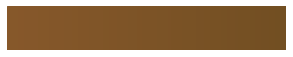

s0
tensor([0.6754, 0.2949, 0.2565])


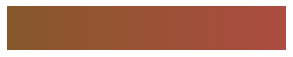

-0.7685936093330383
13.679073115411521
s2
tensor([0.6944, 0.2637, 0.2456])


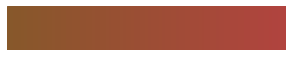

-0.6895312666893005
15.050404311524247


In [16]:
condition = "unseen_fully"
triple_sample = random.choice(list(pragmatic_predict_result_lv2[condition].keys()))
print(triple_sample)
sample = pragmatic_predict_result_lv2[condition][triple_sample]
plt.rcParams['figure.figsize'] = (5.0, 0.8) 
print("ground truth")
plot_color_change_raw(sample["base"][0], sample["true"][0] - sample["base"][0], strength=1)
print("s0")
plot_color_change_raw(sample["base"][0], sample["pred"][0] - sample["base"][0], strength=2)

cos_sim = 1 - spatial.distance.cosine(sample["true"][0] - sample["base"][0], sample["pred"][0] - sample["base"][0])
print(cos_sim)
c1_b = sRGBColor(rgb_r=sample["pred"][0][0], rgb_g=sample["pred"][0][1], rgb_b=sample["pred"][0][2])
c2_b = sRGBColor(rgb_r=sample["true"][0][0], rgb_g=sample["true"][0][1], rgb_b=sample["true"][0][2])
# Convert from RGB to Lab Color Space
color1_lab_b = convert_color(c1_b, LabColor)
# Convert from RGB to Lab Color Space
color2_lab_b = convert_color(c2_b, LabColor)
delta_e_b = delta_e_cie2000(color1_lab_b, color2_lab_b)
print(delta_e_b)

print("s2")
plot_color_change_raw(sample["base"][0], sample["base_pred_pragmatic_s2"][0] - sample["base"][0], strength=2)

cos_sim = 1 - spatial.distance.cosine(sample["true"][0] - sample["base"][0], sample["base_pred_pragmatic_s2"][0] - sample["base"][0])
print(cos_sim)
c1_b = sRGBColor(rgb_r=sample["base_pred_pragmatic_s2"][0][0], rgb_g=sample["base_pred_pragmatic_s2"][0][1], rgb_b=sample["base_pred_pragmatic_s2"][0][2])
c2_b = sRGBColor(rgb_r=sample["true"][0][0], rgb_g=sample["true"][0][1], rgb_b=sample["true"][0][2])
# Convert from RGB to Lab Color Space
color1_lab_b = convert_color(c1_b, LabColor)
# Convert from RGB to Lab Color Space
color2_lab_b = convert_color(c2_b, LabColor)
delta_e_b = delta_e_cie2000(color1_lab_b, color2_lab_b)
print(delta_e_b)

tensor([0.6754, 0.2949, 0.2565])


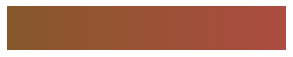

tensor([0.6944, 0.2637, 0.2456])


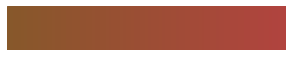

In [17]:
plot_color_change_raw(sample["base"][0], sample["pred"][0] - sample["base"][0], strength=2)
plot_color_change_raw(sample["base"][0], sample["base_pred_pragmatic_s2"][0] - sample["base"][0], strength=2)

In [18]:
sample["pred"]

tensor([[0.6017, 0.3197, 0.2113],
        [0.6400, 0.3218, 0.2087],
        [0.6269, 0.3268, 0.2083],
        [0.6112, 0.3041, 0.2059],
        [0.6581, 0.3366, 0.2216],
        [0.5915, 0.3032, 0.1990],
        [0.5998, 0.3100, 0.2153],
        [0.6378, 0.3322, 0.2285],
        [0.6101, 0.3226, 0.2035],
        [0.6238, 0.3353, 0.2206]])

In [19]:
sample["base"][0]

tensor([0.5280, 0.3446, 0.1662])

In [20]:
sample["true"][0]

tensor([0.4454, 0.3075, 0.1332])